In [91]:
import math

import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
# from scipy.optimize import minimize_scalar

In [92]:
G = 9.80665

In [93]:
class Trebuchet:
    def __init__(self, arm_ratio, frame_height, arm_length, start_angle, release_angle, missile_mass, arm_mass, logging_level=3, include_air_drag=False):
        self.frame_height = frame_height    # Высота вала
        self.arm_ratio = arm_ratio          # Доля рычага, относящаяся к весу
        self.arm_length = arm_length        # Длина рычага
        self.missile_arm_length = arm_length * (1 - arm_ratio)
        self.weight_arm_length = arm_length * arm_ratio

        self.missile_mass = missile_mass
        self.arm_mass = arm_mass

        self.start_angle = np.radians(start_angle)              # Углы по которым полетит снаряд / противовес
        self.release_angle = np.radians(release_angle)
        self.start_arm_angle = np.radians(start_angle + 90)     # Углы концов рычагов
        self.release_arm_angle = np.radians(release_angle + 90)

        self.start_missile_x = np.cos(self.start_arm_angle) * self.missile_arm_length                       # Начальная координата снаряда
        self.start_missile_y = np.sin(self.start_arm_angle) * self.missile_arm_length + self.frame_height
        self.start_weight_x = -np.cos(self.start_arm_angle) * self.weight_arm_length                        # Начальная координата противовеса
        self.start_weight_y = -np.sin(self.start_arm_angle) * self.weight_arm_length + self.frame_height

        self.logging_level = logging_level
        self.include_air_drag = include_air_drag

        if self.logging_level >= 2:
            print(f"Missile start point: ({self.start_missile_x}; {self.start_missile_y})")
            print(f"Weight start point: ({self.start_weight_x}; {self.start_weight_y})")

        self.release_missile_x = np.cos(self.release_arm_angle) * self.missile_arm_length
        self.release_missile_y = np.sin(self.release_arm_angle) * self.missile_arm_length + self.frame_height
        self.release_weight_x = -np.cos(self.release_arm_angle) * self.weight_arm_length
        self.release_weight_y = -np.sin(self.release_arm_angle) * self.weight_arm_length + self.frame_height
        if self.logging_level >= 2:
            print(f"Missile release point: ({self.release_missile_x}; {self.release_missile_y})")
            print(f"Weight release point: ({self.release_weight_x}; {self.release_weight_y})")

        self.weight_h = abs(self.weight_arm_length * (np.cos(self.start_angle) - np.cos(self.release_angle)))

    def calculate_launch_velocity(self, distance):
        x_move = distance - self.release_missile_x      # Перемещение по x
        y_move = 0 - self.release_missile_y             # Перемещение по y
        numerator = G * (x_move ** 2)
        denomenator = 2 * (np.cos(self.release_angle) ** 2) \
            * (x_move * np.tan(self.release_angle) - y_move)
        v0 = math.sqrt(numerator / denomenator)

        if self.logging_level >= 1:
            print(f"Launching missile with angle: {np.degrees(self.release_angle):.2f} degrees and v0: {v0:.2f} m/s")

        return v0

    def calculate_weight_mass(self, v0):
        w_arm = v0 / self.missile_arm_length
        I_arm = self.arm_mass * (self.weight_arm_length ** 2 + self.missile_arm_length ** 2) / 3
        E_k_arm = 0.5 * I_arm * (w_arm ** 2)
        E_k_missile = 0.5 * self.missile_mass * (v0 ** 2)
        E_k_release = E_k_arm + E_k_missile
        weight_mass = E_k_release / (G * self.weight_h)
        return weight_mass

    def trajectory(self, v0):
        v_y = v0 * np.sin(self.release_angle)
        v_x = v0 * np.cos(self.release_angle)

        if self.logging_level >= 1:
            print(f"Vx: {v_x}, Vy: {v_y}")

        first_path_time = v_y / G                           # Время до достижения наивысшей точки
        max_y = self.release_missile_y + v_y * first_path_time - 0.5 * G * (first_path_time ** 2)

        second_path_time = math.sqrt((2 * max_y) / G)       # Время от высшей точки до падения
        total_time = first_path_time + second_path_time     # Общее время полета

        pre_release_t = np.linspace(self.start_arm_angle, self.release_arm_angle, num=10)   # Временные точки
        pre_release_x = np.cos(pre_release_t) * self.missile_arm_length              # Положение по x
        pre_release_y = self.frame_height + np.sin(pre_release_t) * self.missile_arm_length             # Положение по y

        t = np.linspace(0, total_time, num=1000)                # Временные точки
        x = self.release_missile_x + v_x * t                    # Положение по x
        y = self.release_missile_y + v_y * t - 0.5 * G * t**2   # Положение по y

        if self.logging_level >= 1:
            print(f"Flight time: {total_time} s, x_move: {v_x * total_time} m, y_move: {v_y * total_time - 0.5 * G * (total_time)**2} m")
            print(f"Landed in: ({x[-1]}; {self.release_missile_y + v_y * total_time - 0.5 * G * (total_time)**2})")

        return pre_release_x, pre_release_y, x, y

    def visualize(self, distance):
        v0 = self.calculate_launch_velocity(distance)
        weight_mass = self.calculate_weight_mass(v0)
        print(f"Weight mass: {weight_mass}")
        pre_release_x, pre_release_y, x, y = self.trajectory(v0)

        plt.figure(figsize=(10, 5))
        plt.plot([0, 0], [0, self.frame_height], label='Станина', color="black")

        plt.plot([self.release_missile_x, 0], [self.release_missile_y, self.frame_height], label='Метательный рычаг (момент вылета)', color='red')
        plt.plot([0, self.release_weight_x], [self.frame_height, self.release_weight_y], label='Рычаг противовеса (момент вылета)', color='green')

        plt.plot([self.start_missile_x, 0], [self.start_missile_y, self.frame_height], label='Метательный рычаг (начальный момент)', color='red', linestyle='--', alpha=0.8)
        plt.plot([0, self.start_weight_x], [self.frame_height, self.start_weight_y], label='Рычаг противовеса (начальный момент)', color='green', linestyle='--', alpha=0.8)

        plt.plot(0, self.frame_height, marker='o', color='black')
        plt.plot(self.release_missile_x, self.release_missile_y, marker='o', color='red')
        plt.plot(self.release_weight_x, self.release_weight_y, marker='o', color='green')
        plt.plot(self.start_missile_x, self.start_missile_y, marker='o', color='red', alpha=0.8)
        plt.plot(self.start_weight_x, self.start_weight_y, marker='o', color='green', alpha=0.8)

        plt.plot(x, y, label='Траектория полета', color='blue')
        plt.plot(pre_release_x, pre_release_y, label='Траектория до вылета', color='blue', linestyle='--', alpha=0.8)
        plt.xlabel('Дистанция (м)')
        plt.ylabel('Высота (м)')
        plt.title('Траектория полета снаряда требушета')

        plt.grid(True)
        # plt.xlim(self.start_missile_x - 0.1, x[-1] + 0.1)
        # plt.ylim(0, max(y) + 0.1)
        plt.axis('equal')
        plt.legend()
        # plt.xticks(np.arange(0, plt.xlim()[1], 0.1))
        plt.show()

In [105]:
def objective_function(params, target_distance, trebuchet_class, missile_mass=0.04, arm_mass=0.2, frame_height=0.15, start_angle=150):
    arm_ratio, arm_length, release_angle = params

    # Создаем экземпляр требушета с текущими параметрами
    trebuchet = trebuchet_class(
        arm_ratio=arm_ratio,
        arm_length=arm_length,
        frame_height=frame_height,
        start_angle=start_angle,
        release_angle=release_angle,
        missile_mass=missile_mass,
        arm_mass=arm_mass,
        logging_level=0
    )

    # Вычисляем начальную скорость и дальность
    v0 = trebuchet.calculate_launch_velocity(target_distance)
    distance = trebuchet.trajectory(v0)[2][-1]
    weight_mass = trebuchet.calculate_weight_mass(v0)
    print(f"arm_ratio:{params[0]}, arm_length: {params[1]}, angle:{params[2]}")
    print(f"{weight_mass:.2f} Kg")

    # Целевая функция — квадрат ошибки
    return abs(distance - target_distance) + weight_mass


def constraint(params):
    arm_ratio, arm_length, _ = params
    return (1 - arm_ratio) * arm_length * np.sin(np.radians(165)) - arm_length


def optimize_trebuchet_scipy(trebuchet_class, target_distance):
    initial_params = [0.2, 0.25, 45.0]  # [arm_ratio, arm_length, release_angle]

    # Ограничения для параметров
    bounds = [
        (0.01, 0.99),  # arm_ratio
        (0.01, 0.25),  # arm_length
        (1.0, 89.0)  # release_angle
    ]

    # con = {'type': 'ineq', 'fun': constraint}

    # Оптимизация
    result = minimize(
        objective_function,
        x0=initial_params,
        args=(target_distance, trebuchet_class),
        bounds=bounds,
        # constraints=[con],
        method='L-BFGS-B'
    )

    return result.x  # Возвращаем оптимизированные параметры

In [106]:
target_distance = 1.0
optimized_params = optimize_trebuchet_scipy(Trebuchet, target_distance)

print(f"Optimized parameters: arm_ratio={optimized_params[0]:.3f}, arm_length={optimized_params[1]:.3f}, release_angle={optimized_params[2]:.1f}")

arm_ratio:0.2, arm_length: 0.25, angle:45.0
0.64 Kg
arm_ratio:0.20000001, arm_length: 0.25, angle:45.0
0.64 Kg
arm_ratio:0.2, arm_length: 0.24999999, angle:45.0
0.64 Kg
arm_ratio:0.2, arm_length: 0.25, angle:45.00000001
0.64 Kg
arm_ratio:0.99, arm_length: 0.25, angle:44.987655619948484
729.99 Kg
arm_ratio:0.9899999899999999, arm_length: 0.25, angle:44.987655619948484
729.99 Kg
arm_ratio:0.99, arm_length: 0.24999999, angle:44.987655619948484
729.99 Kg
arm_ratio:0.99, arm_length: 0.25, angle:44.987655629948485
729.99 Kg
arm_ratio:0.46228085390118834, arm_length: 0.25, angle:44.99590165248001
0.38 Kg
arm_ratio:0.46228086390118833, arm_length: 0.25, angle:44.99590165248001
0.38 Kg
arm_ratio:0.46228085390118834, arm_length: 0.24999999, angle:44.99590165248001
0.38 Kg
arm_ratio:0.46228085390118834, arm_length: 0.25, angle:44.99590166248001
0.38 Kg
arm_ratio:0.4517797440555746, arm_length: 0.25, angle:44.99553057109864
0.38 Kg
arm_ratio:0.4517797540555746, arm_length: 0.25, angle:44.995530571

In [107]:
target_distance = .5
optimized_params = optimize_trebuchet_scipy(Trebuchet, target_distance)
print(f"Optimized parameters: arm_ratio={optimized_params[0]:.3f}, arm_length={optimized_params[1]:.3f}, release_angle={optimized_params[2]:.1f}")

arm_ratio:0.2, arm_length: 0.25, angle:45.0
0.31 Kg
arm_ratio:0.20000001, arm_length: 0.25, angle:45.0
0.31 Kg
arm_ratio:0.2, arm_length: 0.24999999, angle:45.0
0.31 Kg
arm_ratio:0.2, arm_length: 0.25, angle:45.00000001
0.31 Kg
arm_ratio:0.99, arm_length: 0.25, angle:44.991782351896255
323.26 Kg
arm_ratio:0.9899999899999999, arm_length: 0.25, angle:44.991782351896255
323.26 Kg
arm_ratio:0.99, arm_length: 0.24999999, angle:44.991782351896255
323.26 Kg
arm_ratio:0.99, arm_length: 0.25, angle:44.991782361896256
323.26 Kg
arm_ratio:0.46235577749873275, arm_length: 0.25, angle:44.99727095258548
0.18 Kg
arm_ratio:0.46235578749873274, arm_length: 0.25, angle:44.99727095258548
0.18 Kg
arm_ratio:0.46235577749873275, arm_length: 0.24999999, angle:44.99727095258548
0.18 Kg
arm_ratio:0.46235577749873275, arm_length: 0.25, angle:44.99727096258548
0.18 Kg
arm_ratio:0.45580710721147666, arm_length: 0.25, angle:44.996629616804064
0.18 Kg
arm_ratio:0.45580711721147665, arm_length: 0.25, angle:44.996629

Missile start point: (-0.06250000000000006; 0.041746824526945184)
Weight start point: (0.06250000000000006; 0.2582531754730548)
Missile release point: (-0.06249999999999997; 0.2582531754730548)
Weight release point: (0.06249999999999997; 0.041746824526945156)
Launching missile with angle: 30.00 degrees and v0: 1.88 m/s
Weight mass: 0.1448295664827429
Vx: 1.6312813025047181, Vy: 0.9418206991251022
Flight time: 0.34482096934251655 s, x_move: 0.5624999999999999 m, y_move: -0.25825317547305493 m
Landed in: (0.4999999999999999; -1.1102230246251565e-16)


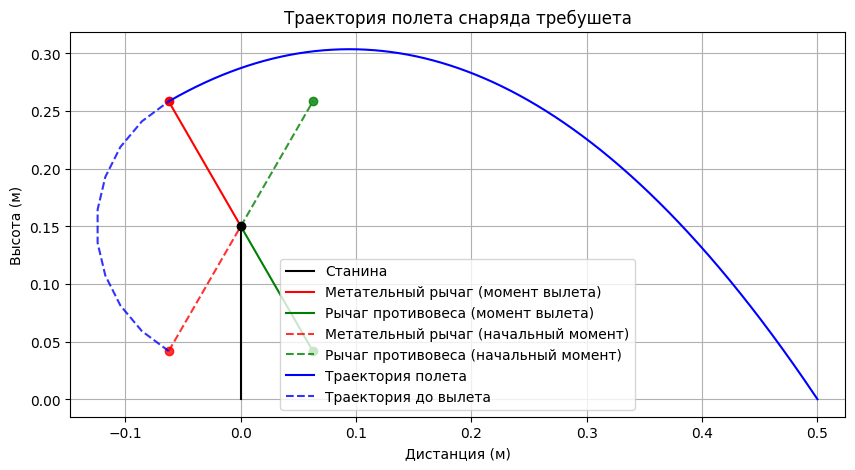

In [129]:
trebuchet = Trebuchet(arm_ratio=0.5, frame_height=0.15, arm_length=0.25, start_angle=150, release_angle=30, missile_mass=0.04, arm_mass=0.2)
trebuchet.visualize(.5)